<div>
<img src="attachment:logo_lfe_powsybl.svg" width="500"/>
</div>

# Introduction to PyPowSyBl: Network representation, load flow calculation, security analysis and sensitivity analysis

@authors: Alexandre Marié ([Artelys](https://www.artelys.com/)), Coline Piloquet ([Rte](https://www.rte-france.com/)), Sophie Frasnedo ([Rte](https://www.rte-france.com/)).

Let's start this notebook by installing and importing pypowsybl!

In [ ]:
pip install pypowsybl

In [ ]:
import pypowsybl as pp

## 1 - Network presentation

The network used for this tutorial consists of 6 voltage levels, all of which are connected by two parallel lines with the same electrotechnical characteristics (same resistance and same reactance for each line), as well as two HVDC lines and a Phase-Shifting Transformer (PST). It also has 4 generating units and 3 loads.

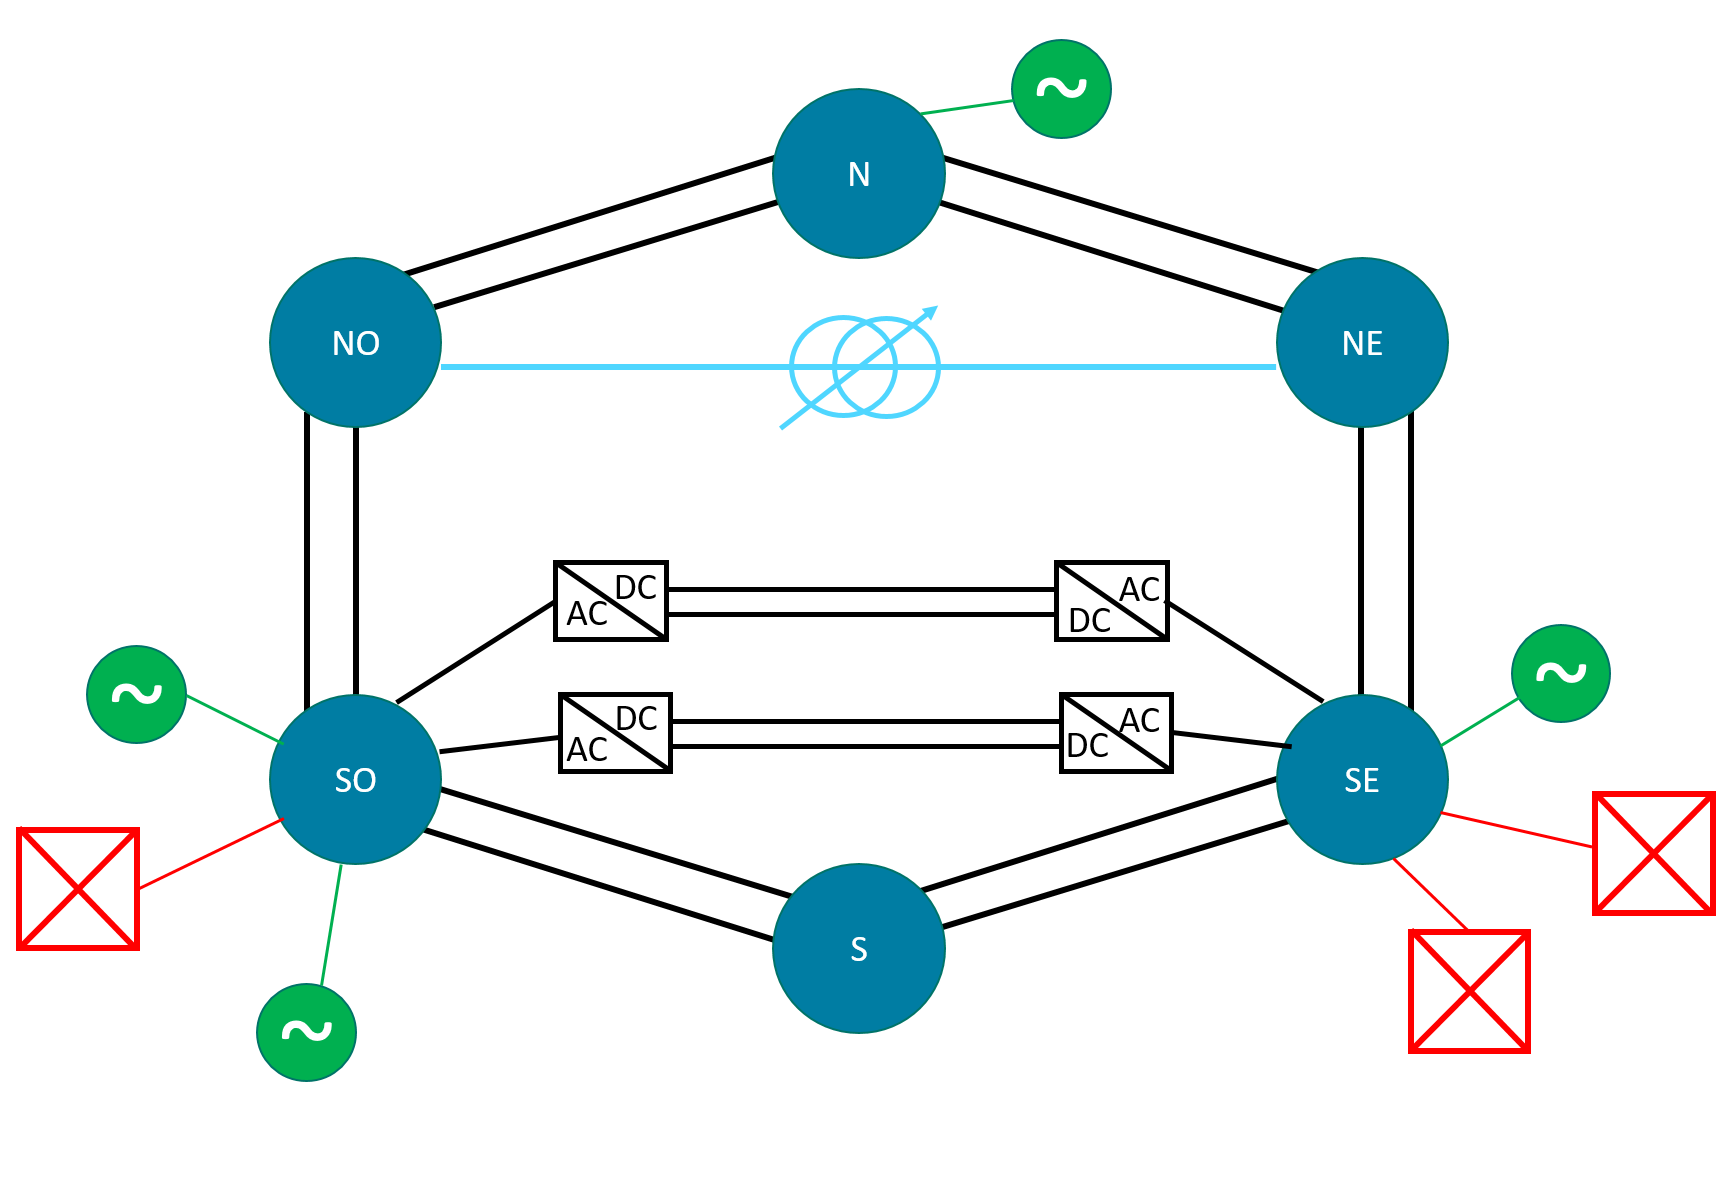

The network is available in the pyPowSyBl library and can be loaded very easily.

In [ ]:
n6 = pp.network.create_metrix_tutorial_six_buses_network()

In order to display the network, we can draw the network area diagram. This type of diagram displays the voltage levels and how they are connected to each other.

In [ ]:
n6.get_network_area_diagram()

If we wish to get a more detailed view of the network, featuring each component (busbars, switches, generators, loads etc.), we can display a single-line diagram.
Here, we chose to display the single-line diagram of the 'SE' substation.

In [ ]:
n6.get_single_line_diagram('SO')

We can display node info:

In [ ]:
n6.get_substations()

Generator info:

In [ ]:
n6.get_generators()

Load info:

In [ ]:
n6.get_loads()

## 2- Production and demand trends

Let's consider that production and demand evolve over 3 hourly time steps:

| Ts | SE_L1 | SO_G1 | SO_G2 |
| --- | --- | --- | --- |
| T01 | 960 | 0 | 960 |
| T02 | 960 | 960 | 0 |
| T03 | 960 | 960 | 0 |


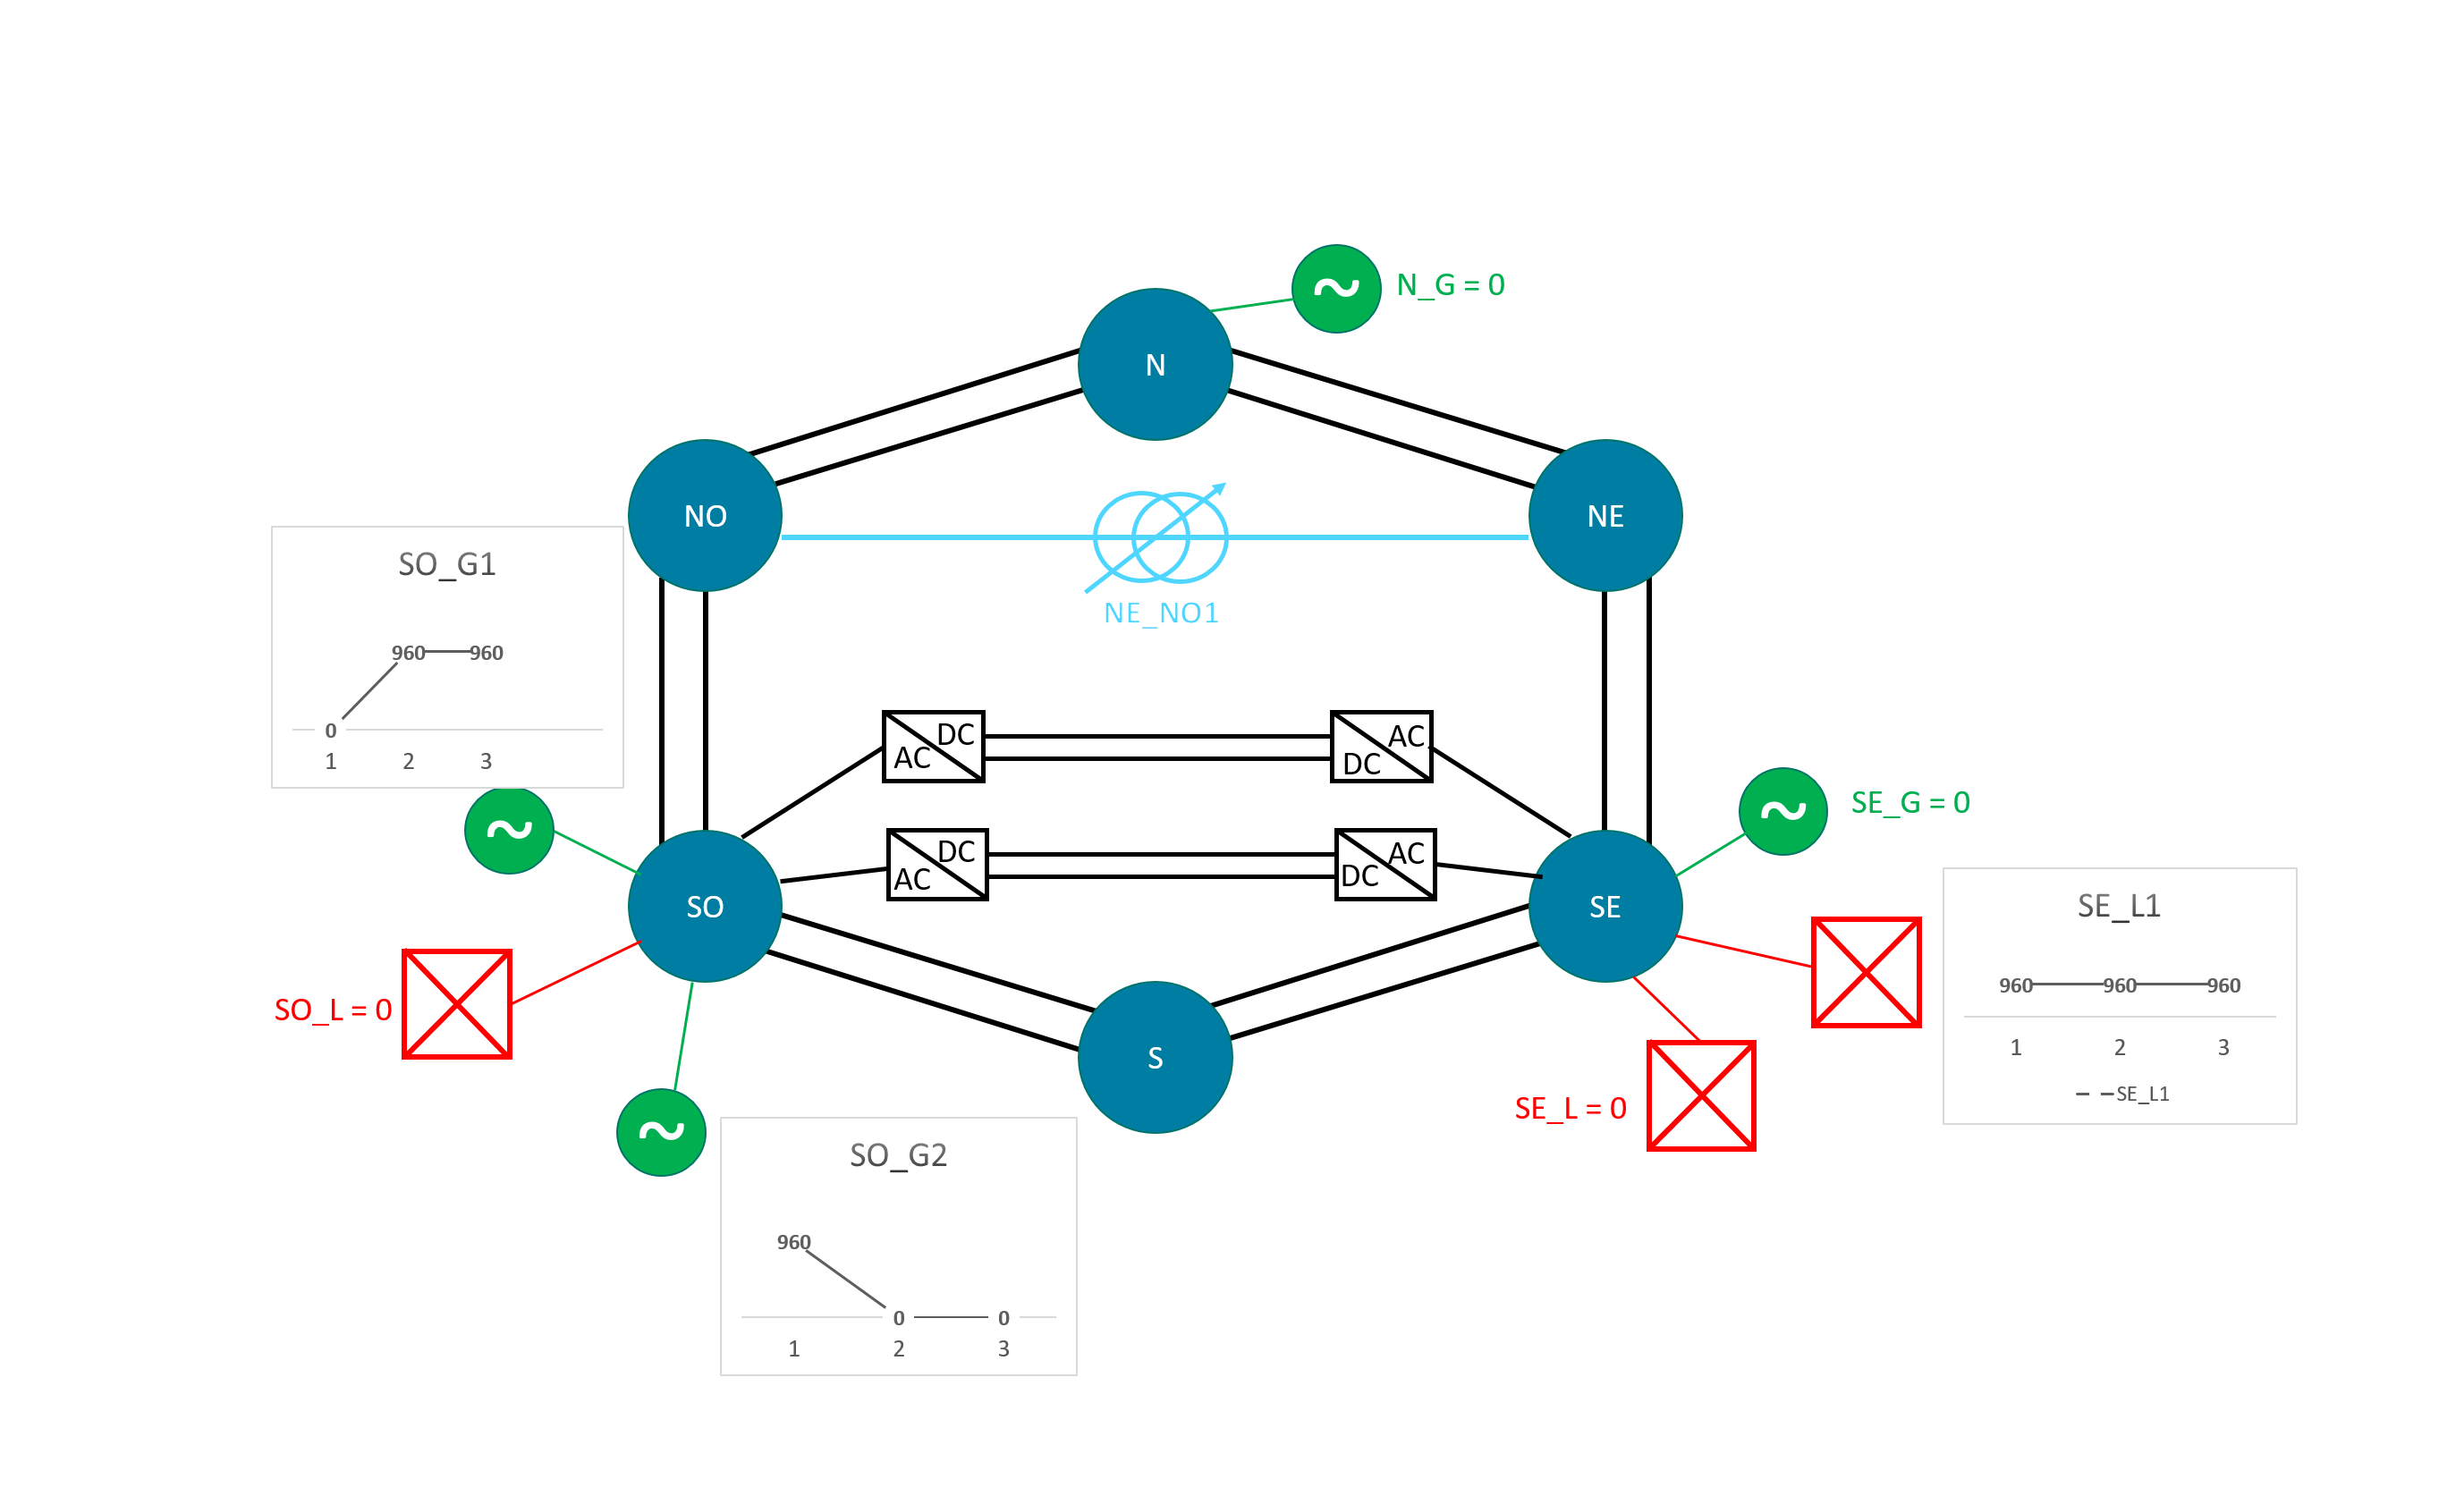

Let's take a look at the first time step and change the production accordingly:

In [ ]:
n6.update_generators(id='SO_G1', target_p=0)
n6.update_generators(id='SO_G2', target_p=960)
n6.update_generators(id='SE_G', target_p=0)

In [ ]:
n6.get_generators()

Then, we modify the active power loads and display the data:

In [ ]:
n6.update_loads(id='SO_L', p0=0)
n6.update_loads(id='SE_L1', p0=960)
n6.update_loads(id='SE_L2', p0=0)

In [ ]:
n6.get_loads()

## 3 - Load flow computation

Let's run a load flow in order to analyze the base case. It is an analysis that calculates the magnitude and angle of the voltage as well as the power flow on each electrical bus of a network. 

The base case (also called the N case) represents the nominal state of the network (no failures).

In [ ]:
results = pp.loadflow.run_dc(n6)

In [ ]:
results

In [ ]:
n6.get_lines()

In [ ]:
n6.get_network_area_diagram()

In the base case, the generating units and the loads are both located south. The flow takes the path of least resistance so it goes mostly through the SO -> S -> SE lines. There is also flow on the PST, and to the north.

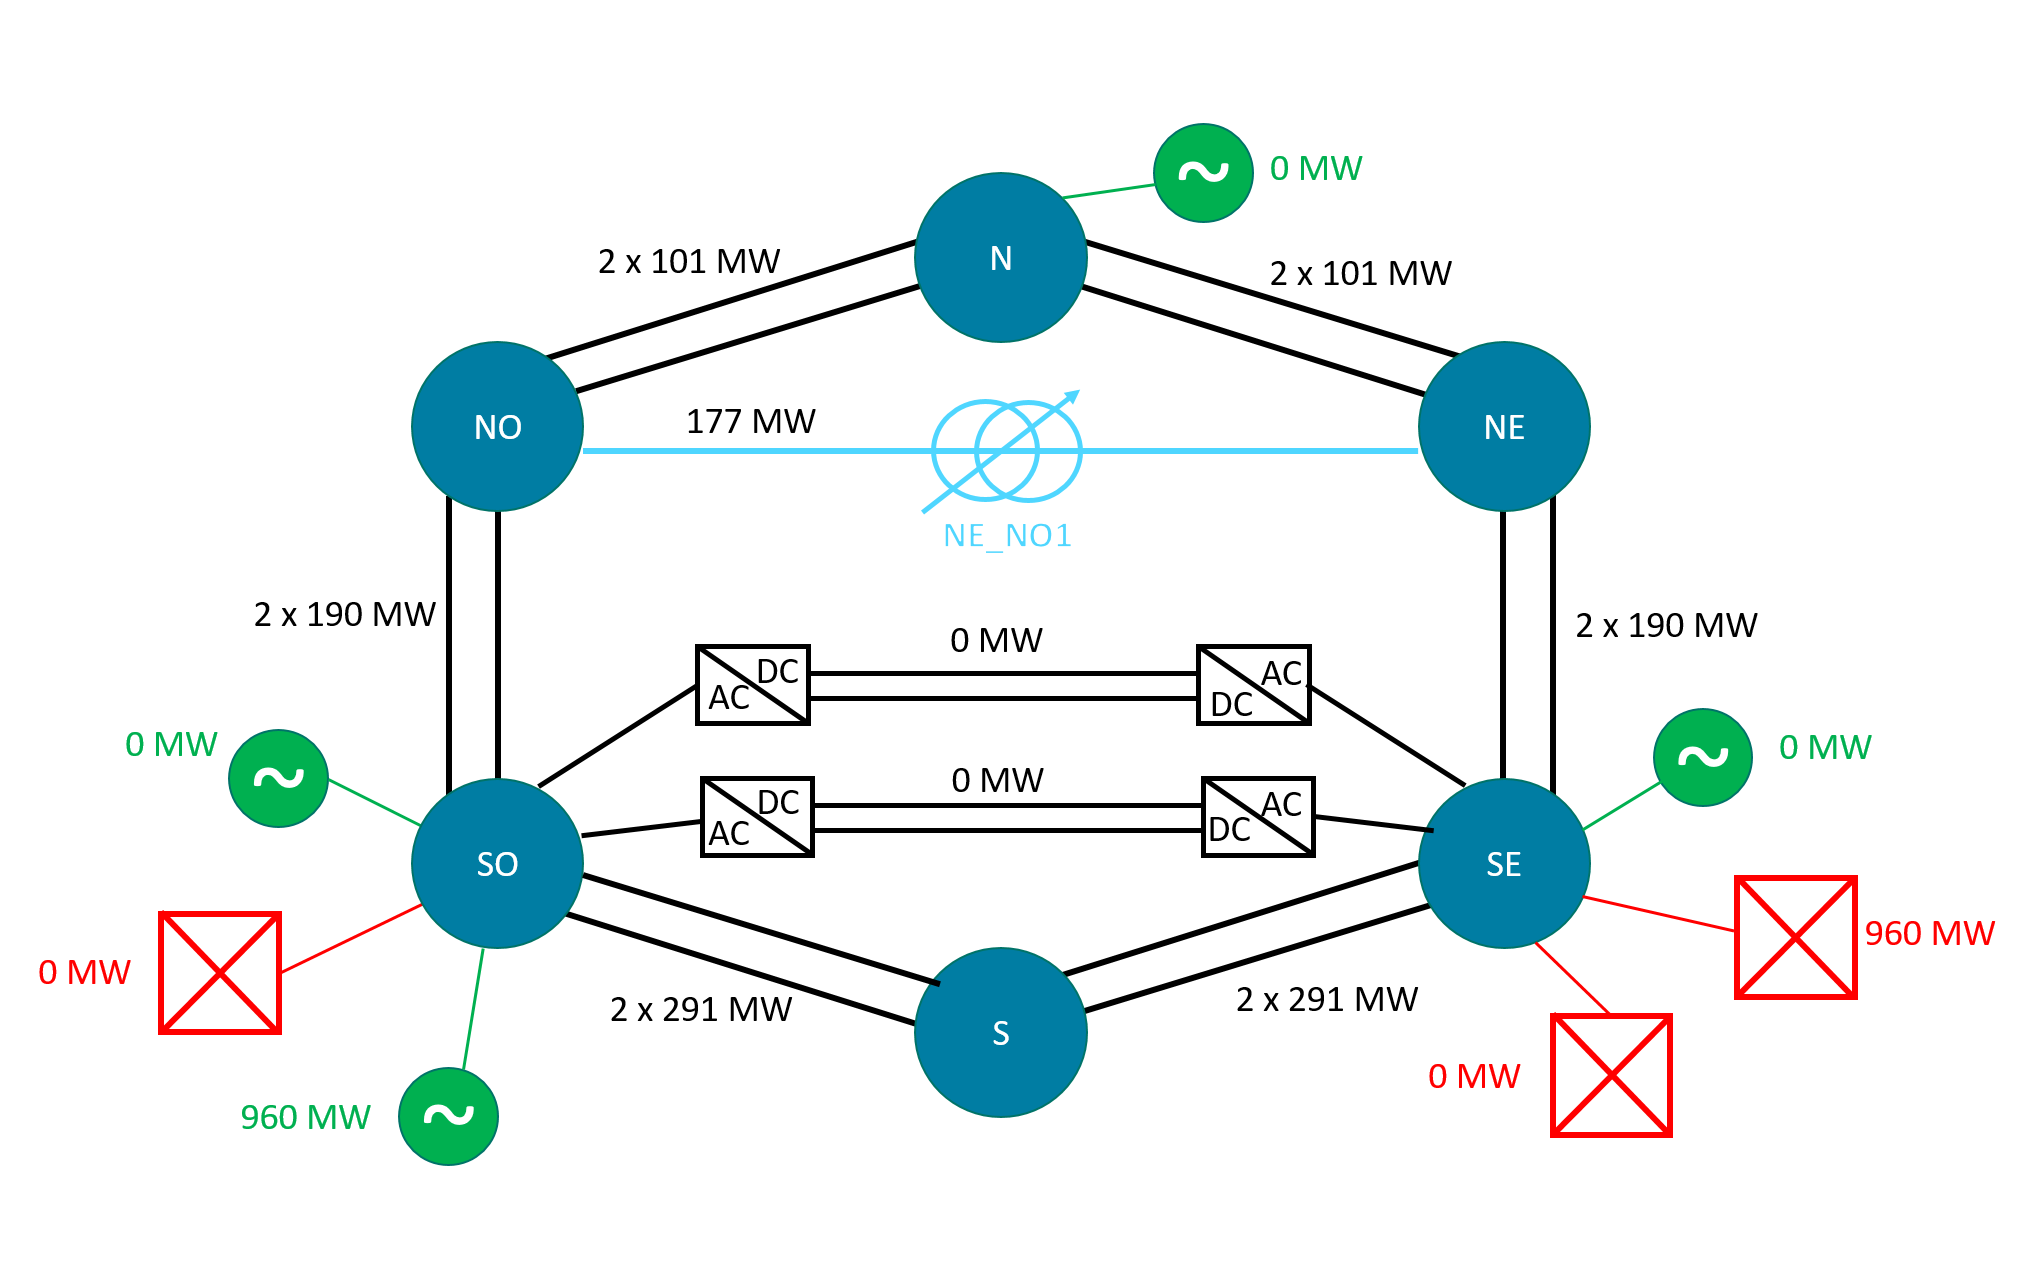

Now, let's assume we're faced with the loss of the `S_SO_1` line. 

This situation is called a N-1 case.

We disconnect the line to simulate its loss.

In [ ]:
n6.disconnect(id='S_SO_1')

In [ ]:
results = pp.loadflow.run_dc(n6)

In [ ]:
results

In [ ]:
n6.get_lines()

In [ ]:
n6.get_network_area_diagram()

The 'S_SO_2' line is overloaded. The network is not secure in this N-1 case.  

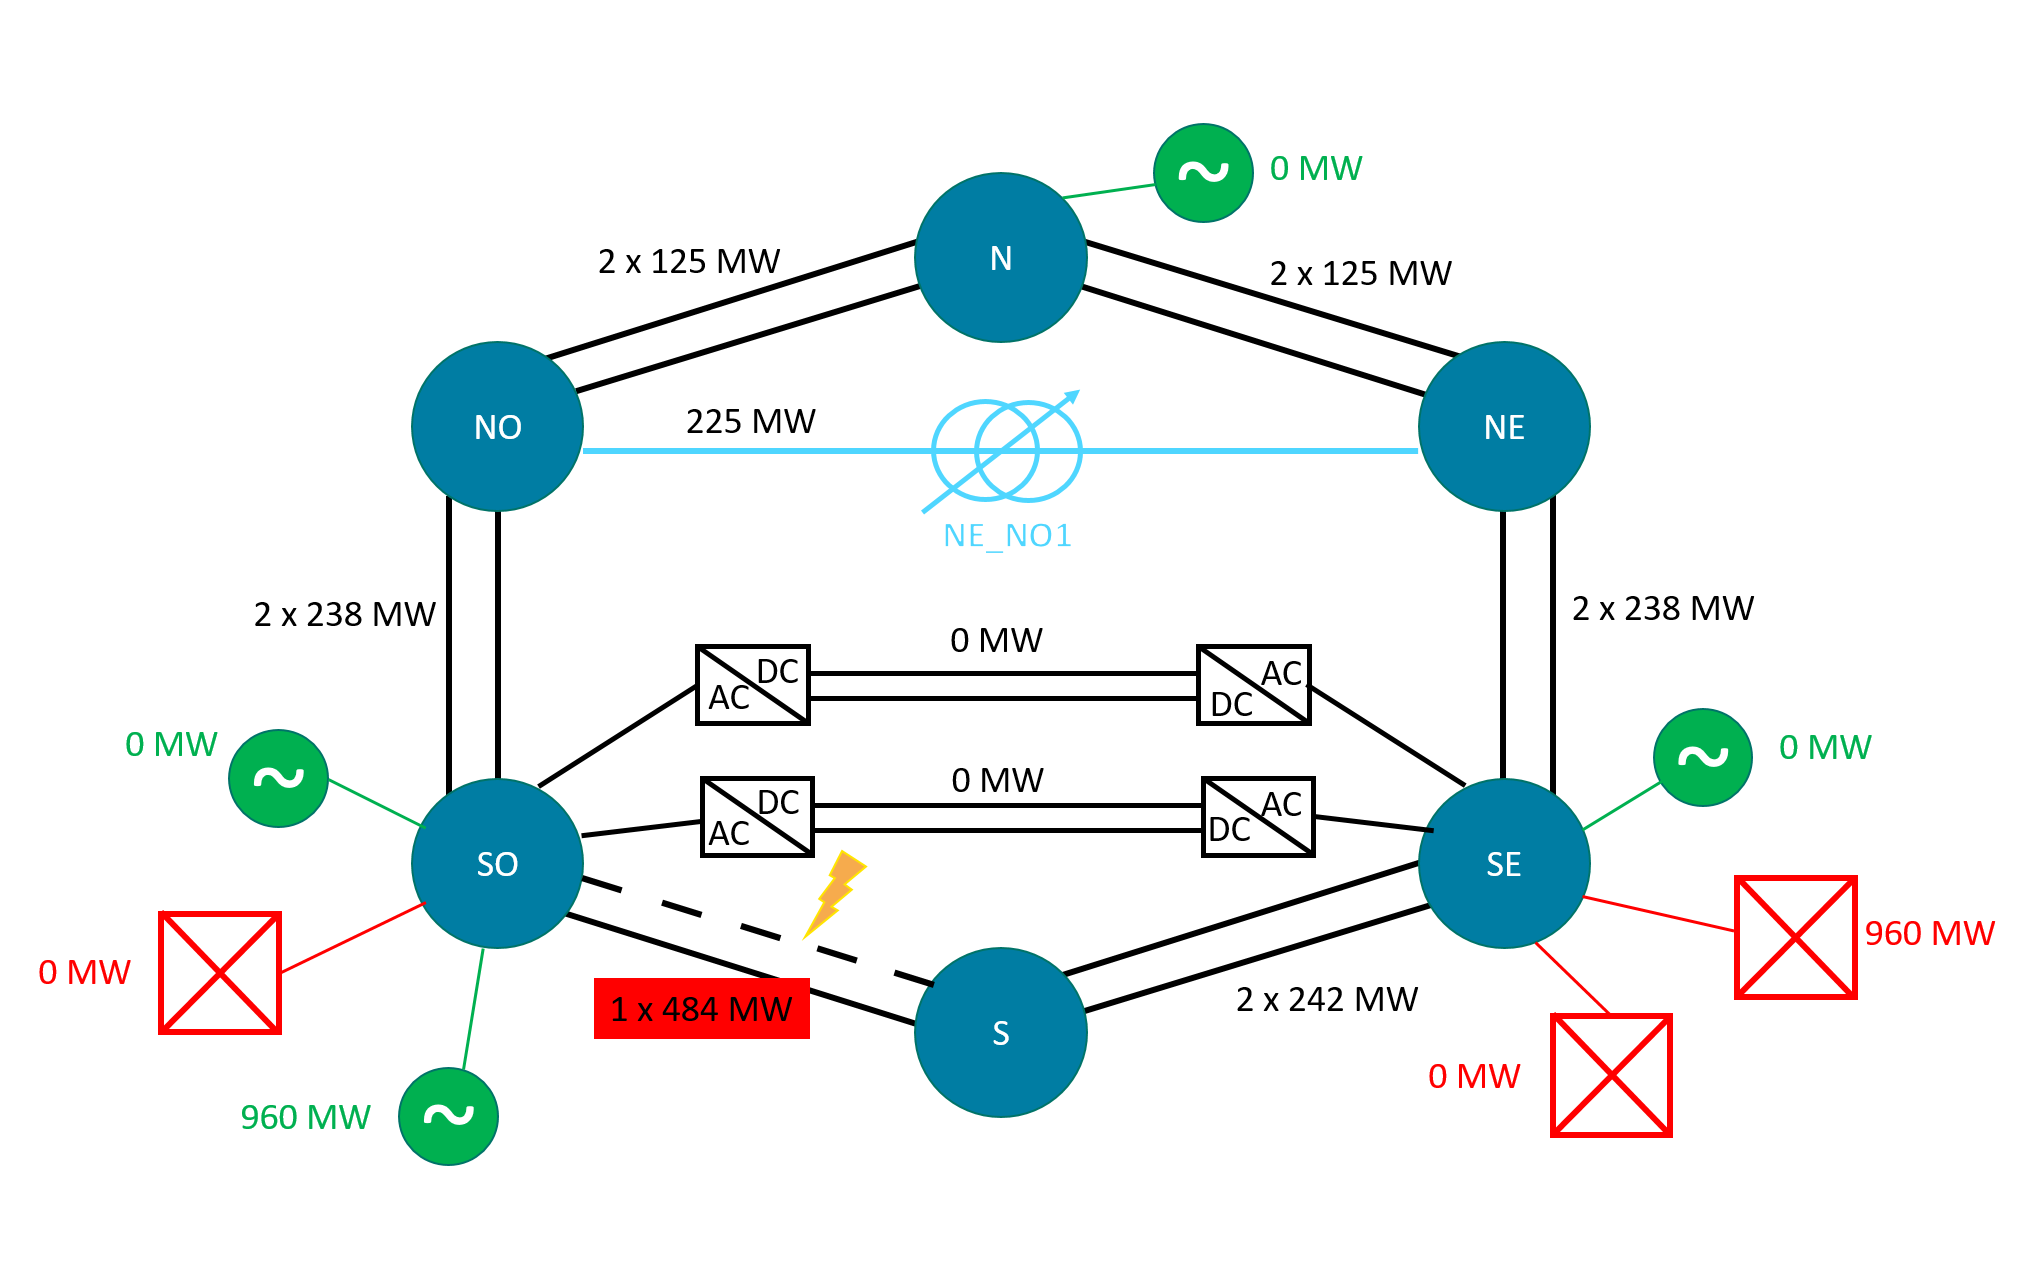

## 4 - Security Analysis

Dispatchers monitor the network in real time. Part of their work is also to anticipate N-1 cases by simulating them and planning actions to be taken if a fault actually occurs.
Manually disconnecting one line, computing a loadflow and checking the limits of every branch of a small network is fastidious. It is nearly impossible on a real network, let alone in real time.
The security analysis deals with that.


Before performing a security analysis, let's reconnect the `S_SO_1` line and consider the second hourly time step. 

In [ ]:
n6.connect(id='S_SO_1')

In [ ]:
n6.update_generators(id='SO_G1', target_p=960)
n6.update_generators(id='SO_G2', target_p=0)

In [ ]:
n6.get_generators()

### 4.1 - Security analysis

In order to perform a security analysis, you need a network and at least one contingency (i.e. one failure) on that network. 

The violations detected without simulating any failure are collected in the `pre_contingency_result`.
The violations detected while simulating a contingency are collected in the `post_contingency_result`.

In [ ]:
security_analysis = pp.security.create_analysis()

In [ ]:
security_analysis.add_single_element_contingency('S_SO_1', 'First contingency')

In [ ]:
sa_result = security_analysis.run_dc(n6)

In [ ]:
sa_result.pre_contingency_result 

There is no pre-contingency violations because the base case is secured.

In [ ]:
sa_result.post_contingency_results

In [ ]:
sa_result.limit_violations

In [ ]:
n6.get_operational_limits().loc['S_SO_2']

The contingency on the `S_SO_1` line leads to an overload on the `S_SO_2` line. 

### 4.2 - Adding monitored Elements

This feature is used to obtain information on various elements of the network after the load flow computations. Information can be obtained on buses, branches and three-winding transformers.

In [ ]:
sa = pp.security.create_analysis()

In [ ]:
# S_SO_1: one of the two lines connecting the S and SO substations
sa.add_single_element_contingencies(['S_SO_1'])

In [ ]:
# S_SO_1 and S_SO_2: lines connecting the S and SO substations
# SO_NO_1 and SO_NO_2: lines connecting the SO and NO substations
sa.add_monitored_elements(branch_ids=['S_SO_2', 'SO_NO_1', 'SO_NO_2', 'S_SO_1'])

In [ ]:
sa_result = sa.run_dc(n6)

In [ ]:
sa_result.limit_violations

In [ ]:
sa_result.branch_results

After the contingency of the line `S_SO_1`, 2/3 of the flow goes to the branch `S_SO_2`, 1/6 to the branch `SO_NO_1` and 1/6 to the branch `SO_NO_2`. 

The power flow limit is exceeded on the branch `S_SO_2`. However, the excess of 84 MW could transit on `SO_NO_1` and `SO_NO_2`. 

There are four possible curative remedial actions to ensure a secure network despite the S_SO_1 contingency:

- Open bus coupler on `SO` (resulting in splitting SO station into two electrical nodes)
- Open bus coupler on `S` (resulting in splitting S station into two electrical nodes)
- Open both couplers
- Open line `S_SO_2`


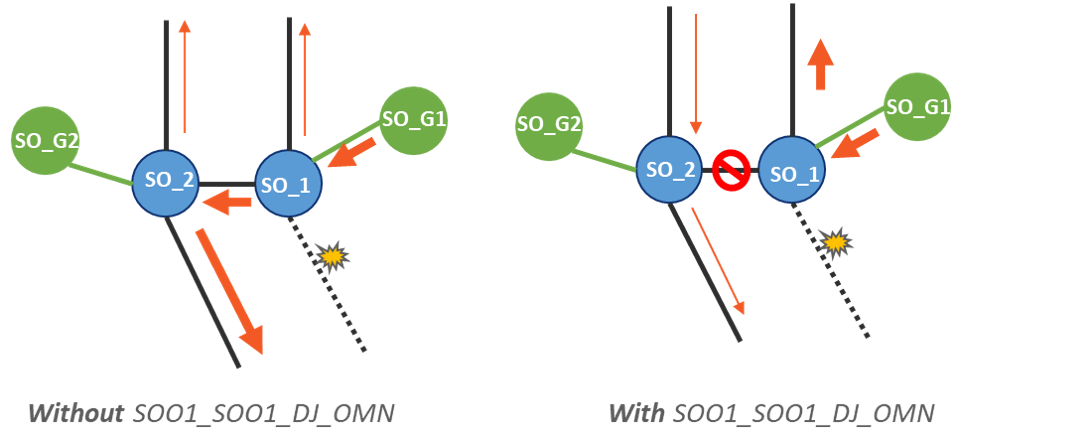

## 5 - Sensitivity Analysis

In case of an increase in electricity demand, the national dispatching center has several production adjustment possibilities.

Two of them are:
- Increasing the production of one or several generators (detailed below)
- Asking its neighbors for help (in a dedicated notebook)

In both cases, the national dispatching center will compute the impact of that adjustement in some chosen parts of the network. This is done by running a sensitivity analysis.


### 5.1 - Increase the production of a generator

We are going to assess the effect of increasing the production of a generator on 2 lines of our network.

In order to perform a sensitivity analysis, you must first define the “factors” you want to compute. 


What we call a factor is the impact of a small variation of a variable (typically the active power injection of a generator, a load or a phase shifter), on a function (typically the active power flow on a branch).

`pypowsybl` provides a method to define the variables (injection, phase shifter) through their ids (variables_ids) and the functions through the branch ids (branches_ids). 

We obtain a matrix of sensitivities as a result:

In [ ]:
# SE_G = generator in the SE voltage level
# S_SO_1 and S_SO_2: lines connecting the S voltage level and the SO voltage level

analysis = pp.sensitivity.create_dc_analysis()
analysis.add_branch_flow_factor_matrix(branches_ids=['S_SO_1', 'S_SO_2'], variables_ids=['SE_G'])
result = analysis.run(n6)

In [ ]:
result.get_sensitivity_matrix()

An increase of 1 MW on generator SE_G impacts the lines S_SO_1 and S_SO_2 with a 0.3 MW increase of the active power flow from side 1 to side 2.


### 5.2 - Transfer electricity production from one zone to another

Now let's imagine that we will transfer the electricity production from one country to another.

This zone-to-zone sensitivity feature is better known as Power Transfer Distribution Factor (PTDF).

There is a dedicated notebook on this topic in the repository (sensitivity_analysis.ipynb)